# Load and Clean the Data

There are four datasets we will need:

* Fights (specific fight details and the bulk of the statistics)
* Fight Results (who won, method, time, details)
* Fighters (tott)
* Events (this provides event data for finding a fighter's last time in the ring)

In [1]:
import pandas as pd
import numpy as np
import re
from datetime import datetime, timedelta

fights_df = pd.read_csv('scrape_ufc_stats/ufc_fight_stats.csv').dropna()
fight_results_df = pd.read_csv('scrape_ufc_stats/ufc_fight_results.csv').dropna()
fighters_df = pd.read_csv('scrape_ufc_stats/ufc_fighter_tott.csv').dropna()
events_df = pd.read_csv('scrape_ufc_stats/ufc_event_details.csv').dropna()

### Clean Fights DataFrame

In [2]:
""" Drop null """
# fights_df.dropna(inplace=True)

""" Rename columns """
def standardize_col (col_name: str) -> str:
    out = col_name.lower()
    out = out.replace('.', ' ')
    out = out.replace('%', 'pct')
    out = out.strip().replace(' ', '_')
    out = out.replace('__', '_')
    return out

fights_df.rename(columns={i: standardize_col(i) for i in fights_df.columns}, inplace=True)

""" Clean columns """

# Remove 'Round' from round col
fights_df['round'] = fights_df['round'].map(lambda x: int(x.split(' ')[1])) # 'Round 1' -> 1

# Separate out columns with 'x of y' in them into two cols (e.g. 'head' and 'head_att' for head attempts)
def separate_ratio_col (df: pd.DataFrame, col_name: str) -> pd.Series:
    df[f'{col_name}_att'] = df[col_name].map(lambda x: int(x.split(' of ')[1]))
    df[col_name] = df[col_name].map(lambda x: int(x.split(' of ')[0]))

separate_ratio_col(fights_df, 'sig_str')
separate_ratio_col(fights_df, 'total_str')
separate_ratio_col(fights_df, 'td')
separate_ratio_col(fights_df, 'head')
separate_ratio_col(fights_df, 'body')
separate_ratio_col(fights_df, 'leg')
separate_ratio_col(fights_df, 'distance')
separate_ratio_col(fights_df, 'clinch')
separate_ratio_col(fights_df, 'ground')

# Remove percent signs
def remove_percent (x):
    if x != '---':
        return float(x.replace('%', ''))
    else:
        return np.nan
fights_df.sig_str_pct = fights_df.sig_str_pct.map(remove_percent)
fights_df.td_pct = fights_df.td_pct.map(remove_percent)

def time_to_sec (x):
    if x != '--':
        parts = x.split(':')
        return int(parts[0]) * 60 + int(parts[1])
    return np.nan
    
fights_df.ctrl = fights_df.ctrl.map(time_to_sec)

def get_opponent_name (x):
    fighters = np.unique(x)
    temp = []
    for fighter in x:
        if fighter == fighters[0]:
            temp.append(fighters[1])
        else:
            temp.append(fighters[0])
    return temp

""" Aggregate Round Data """
opponent_mapping = fights_df.groupby(['event', 'bout', 'round'])['fighter'].transform(get_opponent_name)
fights_df['opponent_name'] = opponent_mapping

fights_df = fights_df.merge(fights_df, left_on=['event', 'bout', 'round', 'opponent_name'], right_on=['event', 'bout', 'round', 'fighter'], suffixes=('', '_allowed'))

fights_df.drop(columns=['fighter_allowed', 'sig_str_pct', 'td_pct', 'sig_str_pct_allowed', 'td_pct_allowed', 'opponent_name_allowed'], inplace=True)

fights_df.head()

,event,bout,round,fighter,kd,sig_str,total_str,td,sub_att,rev,...,ground_allowed,sig_str_att_allowed,total_str_att_allowed,td_att_allowed,head_att_allowed,body_att_allowed,leg_att_allowed,distance_att_allowed,clinch_att_allowed,ground_att_allowed
0,UFC Fight Night: Gane vs. Spivac,Ciryl Gane vs. Serghei Spivac,1,Ciryl Gane,0.0,51,52,0,0.0,0.0,...,0,26,26,1,23,1,2,26,0,0
1,UFC Fight Night: Gane vs. Spivac,Ciryl Gane vs. Serghei Spivac,2,Ciryl Gane,0.0,58,58,0,0.0,0.0,...,0,18,18,0,15,2,1,18,0,0
2,UFC Fight Night: Gane vs. Spivac,Ciryl Gane vs. Serghei Spivac,1,Serghei Spivac,0.0,7,7,0,0.0,0.0,...,0,69,70,0,32,24,13,68,1,0
3,UFC Fight Night: Gane vs. Spivac,Ciryl Gane vs. Serghei Spivac,2,Serghei Spivac,0.0,4,4,0,0.0,0.0,...,0,87,87,0,53,25,9,84,3,0
4,UFC Fight Night: Gane vs. Spivac,Manon Fiorot vs. Rose Namajunas,1,Manon Fiorot,0.0,18,18,0,0.0,0.0,...,0,56,57,2,37,8,11,56,0,0


In [3]:
fights_df.columns

Index(['event', 'bout', 'round', 'fighter', 'kd', 'sig_str', 'total_str', 'td',
       'sub_att', 'rev', 'ctrl', 'head', 'body', 'leg', 'distance', 'clinch',
       'ground', 'sig_str_att', 'total_str_att', 'td_att', 'head_att',
       'body_att', 'leg_att', 'distance_att', 'clinch_att', 'ground_att',
       'opponent_name', 'kd_allowed', 'sig_str_allowed', 'total_str_allowed',
       'td_allowed', 'sub_att_allowed', 'rev_allowed', 'ctrl_allowed',
       'head_allowed', 'body_allowed', 'leg_allowed', 'distance_allowed',
       'clinch_allowed', 'ground_allowed', 'sig_str_att_allowed',
       'total_str_att_allowed', 'td_att_allowed', 'head_att_allowed',
       'body_att_allowed', 'leg_att_allowed', 'distance_att_allowed',
       'clinch_att_allowed', 'ground_att_allowed'],
      dtype='object')

### Clean Fight Results DataFrame

### Create Fighter Record DataFrame

In [4]:
fight_results_df.rename(columns={i: standardize_col(i) for i in fight_results_df.columns}, inplace=True)

fight_results_df['fighter_left'] = fight_results_df.bout.map(lambda x: x.split(' vs. ')[0])
fight_results_df['fighter_right'] = fight_results_df.bout.map(lambda x: x.split(' vs. ')[1])
fight_results_df['outcome_left'] = fight_results_df.outcome.map(lambda x: x.split('/')[0].strip())
fight_results_df['outcome_right'] = fight_results_df.outcome.map(lambda x: x.split('/')[1].strip())

# left = fight_results_df[['fighter_left', 'outcome_left']].copy().rename(columns={'fighter_left': 'fighter', 'outcome_left': 'outcome'})
# right = fight_results_df[['fighter_right', 'outcome_right']].copy().rename(columns={'fighter_right': 'fighter', 'outcome_right': 'outcome'})

# fighter_record_df = pd.concat([left, right], axis=0, ignore_index=True)
left = fight_results_df[['event', 'bout', 'weightclass', 'method', 'round', 'time', 'time_format', 'referee', 'details', 'fighter_left', 'outcome_left']] \
    .rename(columns={'fighter_left': 'fighter', 'outcome_left': 'outcome'})
right = fight_results_df[['event', 'bout', 'weightclass', 'method', 'round', 'time', 'time_format', 'referee', 'details', 'fighter_right', 'outcome_right']] \
    .rename(columns={'fighter_right': 'fighter', 'outcome_right': 'outcome'})

fight_results_df = pd.concat([left, right])

normal_methods = set(['KO/TKO', 'Decision - Unanimous', 'Decision - Split', 'Submission', "TKO - Doctor's Stoppage"])
fight_results_df.method = fight_results_df.method.map(lambda x: x.strip())
fight_results_df['ko_tko'] = (fight_results_df.method == 'KO/TKO').astype(int)
fight_results_df['unanimous_decision'] = (fight_results_df.method == 'Decision - Unanimous').astype(int)
fight_results_df['split_decision'] = (fight_results_df.method == 'Decision - Split').astype(int)
fight_results_df['submission'] = (fight_results_df.method == 'Submission').astype(int)
fight_results_df['dr_stoppage'] = (fight_results_df.method == "TKO - Doctor's Stoppage").astype(int)
fight_results_df['other'] = fight_results_df.method.map(lambda x: 0 if x in normal_methods else 0)

fight_results_df.event = fight_results_df.event.apply(lambda x: x.strip())

fight_results_df.bout = fight_results_df.bout.apply(lambda x: x.strip())
fight_results_df.bout = fight_results_df.bout.apply(lambda x: x.replace('  ', ' '))

fight_results_df.fighter = fight_results_df.fighter.apply(lambda x: x.strip())

fight_results_df = fight_results_df[(fight_results_df['time_format'] == '5 Rnd (5-5-5-5-5)') | (fight_results_df['time_format'] == '3 Rnd (5-5-5)')]
fight_results_df.time = fight_results_df.time.map(time_to_sec)

fight_results_df.head()

,event,bout,weightclass,method,round,time,time_format,referee,details,fighter,outcome,ko_tko,unanimous_decision,split_decision,submission,dr_stoppage,other
0,UFC Fight Night: Gane vs. Spivac,Ciryl Gane vs. Serghei Spivac,Heavyweight Bout,KO/TKO,2,224,5 Rnd (5-5-5-5-5),Marc Goddard,Punches to Head At Distance,Ciryl Gane,W,1,0,0,0,0,0
1,UFC Fight Night: Gane vs. Spivac,Manon Fiorot vs. Rose Namajunas,Women's Flyweight Bout,Decision - Unanimous,3,300,3 Rnd (5-5-5),Rich Mitchell,Darryl Ransom 27 - 30.Sal D'amato 28 - 29.Ande...,Manon Fiorot,W,0,1,0,0,0,0
2,UFC Fight Night: Gane vs. Spivac,Benoit Saint Denis vs. Thiago Moises,Lightweight Bout,KO/TKO,2,284,3 Rnd (5-5-5),Lukasz Bosacki,Punches to Head On Ground,Benoit Saint Denis,W,1,0,0,0,0,0
3,UFC Fight Night: Gane vs. Spivac,Volkan Oezdemir vs. Bogdan Guskov,Light Heavyweight Bout,Submission,1,226,3 Rnd (5-5-5),Marc Goddard,Rear Naked Choke,Volkan Oezdemir,W,0,0,0,1,0,0
4,UFC Fight Night: Gane vs. Spivac,William Gomis vs. Yanis Ghemmouri,Featherweight Bout,KO/TKO,3,140,3 Rnd (5-5-5),Loic Pora,Kick to Body At Distance,William Gomis,W,1,0,0,0,0,0


In [5]:
# fighter_records_df = (fighter_record_df.groupby('fighter').value_counts().unstack().reset_index())
# fighter_records_df.columns.name = None
# for col in fighter_records_df.columns:
#     fighter_records_df[col].fillna(0, inplace=True)

# fighter_records_df.fighter = fighter_records_df.fighter.map(lambda x: x.strip())
# fighter_records_df.head()
# fighter_records_df.loc[fighter_records_df['fighter'] == 'Sean O\'Malley']

fighter_records_df = pd.read_json('ufc_data/all_fighter_stats.json')[['name', 'wins', 'losses', 'draws']]
fighter_records_df.wins = fighter_records_df.wins.map(lambda x: int(x)).astype(int)
fighter_records_df.losses = fighter_records_df.losses.map(lambda x: int(x)).astype(int)

DRAWS_RE = re.compile(r'(\d+)(\s\((\d+)\sNC\))?')
def get_nc_from_draws (x: str) -> int:
    match = DRAWS_RE.match(x)
    if match.group(2):
        return int (match.group(3))
    else:
        return 0
def clean_draws (x: str) -> int:
    match = DRAWS_RE.match(x)
    return int(match.group(1))

fighter_records_df['nc'] = fighter_records_df.draws.map(get_nc_from_draws)
fighter_records_df.draws = fighter_records_df.draws.map(clean_draws)
fighter_records_df['wl_ratio'] = fighter_records_df.wins / fighter_records_df.losses

fighter_records_df.head()


,name,wins,losses,draws,nc,wl_ratio
0,Brian Ebersole,51,18,1,1,2.833333
1,Rafael Fiziev,12,2,0,0,6.000000
2,Luciano Azevedo,17,9,1,0,1.888889
3,Luiz Azeredo,15,10,0,0,1.500000
4,Dan Christison,20,7,0,0,2.857143


### Clean Fighters DataFrame

In [6]:


fighters_df.rename(columns={i: standardize_col(i) for i in fighters_df.columns}, inplace=True)

HEIGHT_RE = re.compile(r'(\d)\' (\d+)"')
def height_to_int (height: str) -> int:
    match = re.match(HEIGHT_RE, height)
    if match:
        return 12 * int(match.group(1)) + int(match.group(2))
    return np.nan
    
def reach_to_int (reach: str) -> int:
    if reach == '--':
        return np.nan
    return int(reach.replace('"', ''))

def weight_to_int (weight: str) -> int:
    if weight == '--':
        return np.nan
    return int(weight.split(' ')[0])

def dob_to_age (dob: str) -> int:
    if dob == '--':
        return np.nan
    return int((datetime.now() - datetime.strptime(dob, '%b %d, %Y')).days / 365)

fighters_df.height = fighters_df.height.map(height_to_int)
fighters_df.weight = fighters_df.weight.map(weight_to_int)
fighters_df.reach = fighters_df.reach.map(reach_to_int)
fighters_df['age'] = fighters_df.dob.map(dob_to_age)

# fighters_df['wins'] = outcomes

fighters_df.head()

,fighter,height,weight,reach,stance,dob,url,age
0,Tom Aaron,NaN,155.0,NaN,NaN,"Jul 13, 1978",http://ufcstats.com/fighter-details/93fe7332d1...,45.0
1,Danny Abbadi,71.0,155.0,NaN,Orthodox,"Jul 03, 1983",http://ufcstats.com/fighter-details/15df64c02b...,40.0
2,David Abbott,72.0,265.0,NaN,Switch,--,http://ufcstats.com/fighter-details/b361180739...,NaN
3,Shamil Abdurakhimov,75.0,235.0,76.0,Orthodox,"Sep 02, 1981",http://ufcstats.com/fighter-details/2f5cbecbbe...,42.0
4,Hiroyuki Abe,66.0,145.0,NaN,Orthodox,--,http://ufcstats.com/fighter-details/c0ed7b2081...,NaN


In [7]:
# print(fight_results_df.iloc[0].event)
fights_df.iloc[0].event

'UFC Fight Night: Gane vs. Spivac'

### Clean Events DataFrame

In [8]:
events_df.rename(columns={i: standardize_col(i) for i in events_df.columns}, inplace=True)
events_df.date = events_df.date.map(lambda x: datetime.strptime(x, '%B %d, %Y'))

events_df.head()

,event,url,date,location
0,UFC Fight Night: Gane vs. Spivac,http://ufcstats.com/event-details/ef61d9f5176b...,2023-09-02,"Paris, Ile-de-France, France"
1,UFC Fight Night: Holloway vs. The Korean Zombie,http://ufcstats.com/event-details/89a407032911...,2023-08-26,"Kallang, Singapore"
2,UFC 292: Sterling vs. O'Malley,http://ufcstats.com/event-details/2719f300b043...,2023-08-19,"Boston, Massachusetts, USA"
3,UFC Fight Night: Luque vs. Dos Anjos,http://ufcstats.com/event-details/d2fa318f34d0...,2023-08-12,"Las Vegas, Nevada, USA"
4,UFC Fight Night: Sandhagen vs. Font,http://ufcstats.com/event-details/6f81b6de2557...,2023-08-05,"Nashville, Tennessee, USA"


### Features Engineering: Simple Model

In the simple model, we will aggregate all past fighter stats and round level into a vector representing the fighter. We will
use features like the following:

* ~~method~~
* ~~round~~
* ~~time~~
* ~~time_format~~
* ~~reach~~
* ~~age~~
* ~~height~~
* ~~knockdowns~~
* days_since_last_comp
* sub
* ~~reversals~~
* ~~control~~
* ~~takedowns~~
* ~~sig_strikes~~
* ~~strikes~~
* ~~head_strikes~~
* ~~body_strikes~~
* ~~leg_strikes~~
* ~~distance_strikes~~
* ~~clinch_strikes~~
* ~~ground_strikes~~
* comp_time (?)
* num_fights
* win_streak
* lose_streak
* ~~win_loss_ratio~~
* KO_losses
* stamina
* elo

We will also engineer more features by looking at per minute changes, fighter differentials, accuracy, fight to fight change, etc.

Then, we will aggregate rounds into test data for prediction. We will use this dataset to test a variety of models like random forest, xgboost classifier, SVM and NN.

This is a good basis to start

In [9]:
""" Compile round-level stats in fights_df into fight-level stats """

def get_bout_fighter_output_trend (group, columns):
    res = pd.DataFrame()
    # res.set_index(group.index)
    for col in columns:
        x = group['round'].values.astype(float)
        y = group[col].values.astype(float)
        A = np.vstack([x, np.ones(len(x))]).T
        m, _ = np.linalg.lstsq(A, y, rcond=None)[0]
        res[f'{col}_trend'] = [m]
    return res

# fights_df = fights_df.dropna()

sum_columns = list(set(fights_df.columns) - set(['round', 'opponent_name', 'event', 'bout', 'fighter']))
fight_stats_df = fights_df.groupby(['event', 'bout', 'fighter'])[sum_columns].sum().reset_index()
trends = fights_df.groupby(['event', 'bout', 'fighter'])[[*sum_columns, 'round']].apply(lambda x: get_bout_fighter_output_trend(x, sum_columns))

fight_stats_df = fight_stats_df.merge(events_df[['event', 'date']], how='left', on='event')
fight_stats_df = fight_stats_df.merge(fight_results_df, how='left', on=['event', 'bout', 'fighter'])
fight_stats_df = fight_stats_df.merge(trends, how='left', on=['event', 'bout', 'fighter'])

fight_stats_df.rename(columns={'time': 'last_round_time'}, inplace=True)
        
fight_stats_df['total_time'] = fight_stats_df.apply(lambda x: (x['round'] - 1) * 300 + x['last_round_time'], axis=1)

In [10]:
len(fight_stats_df.index)

Index(['event', 'bout', 'fighter', 'sig_str_allowed', 'rev_allowed', 'ctrl',
       'body_att_allowed', 'head_att_allowed', 'ground_att_allowed',
       'head_att',
       ...
       'clinch_att_trend', 'clinch_allowed_trend', 'ctrl_allowed_trend',
       'sig_str_att_trend', 'sig_str_att_allowed_trend', 'rev_trend',
       'clinch_att_allowed_trend', 'td_allowed_trend', 'sub_att_trend',
       'total_time'],
      dtype='object', length=107)

### Make Main Dataset

In [11]:
""" Make fight-level engineered features """

round_quant_columns = list(set(fight_stats_df.columns) - \
                     set(['event', 'bout', 'fighter', 'round', 'date', 'weightclass', 
                      'method', 'last_round_time', 'time_format', 'total_time', 'referee', 'outcome', 'ko_tko',
                      'unanimous_decision', 'split_decision', 'submission', 
                      'dr_stoppage', 'other', 'details']))

for col in round_quant_columns:
    if not col.endswith('_allowed'):
        """ Make differential columns """
        fight_stats_df[f'{col}_diff'] = fight_stats_df[col] / fight_stats_df[f'{col}_allowed']

    """ Make per minute columns """
    fight_stats_df[f'{col}_per_min'] = fight_stats_df[col] / fight_stats_df['total_time'] * 60

""" Make striking accuracy (ratio) columns """
accuracy_columns = list(set(round_quant_columns) - set(['kd', 'kd_allowed', 'ctrl', 'ctrl_allowed', 'rev', 'rev_allowed']))
for col in accuracy_columns:
    if (not col.endswith('_att')) and (not col.endswith('_att_allowed')):
        if col.endswith('_allowed'):
            name = col.split('_allowed')[0]
            fight_stats_df[f'{col}_accuracy'] = fight_stats_df[col] / fight_stats_df[f'{name}_att_allowed']
        else:
            fight_stats_df[f'{col}_accuracy'] = fight_stats_df[col] / fight_stats_df[f'{col}_att']

print (fight_stats_df.columns)

KeyError: 'kd_trend_allowed'

In [ ]:
rows = len(fight_stats_df.index)
training_df = fight_stats_df.iloc[:int(rows * 0.8)]
test_df = fight_stats_df.iloc[int(rows * 0.8):]


In [ ]:
""" Make fighter-level dataset """

fight_stats_df.groupby(['fighter'])

In [ ]:
training_df.head()

,event,bout,fighter,ctrl,clinch,rev,sig_str_att_allowed,ctrl_allowed,td_allowed,body_allowed,...,td_accuracy,distance_accuracy,ground_accuracy,sig_str_accuracy,total_str_accuracy,clinch_allowed_accuracy,leg_accuracy,td_allowed_accuracy,total_str_allowed_accuracy,distance_allowed_accuracy
0,Ortiz vs Shamrock 3: The Final Chapter,Jason MacDonald vs. Ed Herman,Ed Herman,78.0,0,1.0,7,57.0,0,0,...,0.5,1.000000,NaN,1.000000,1.000000,NaN,1.0,0.0,0.875000,0.500000
1,Ortiz vs Shamrock 3: The Final Chapter,Jason MacDonald vs. Ed Herman,Jason MacDonald,57.0,0,1.0,2,78.0,1,0,...,0.0,0.500000,1.00000,0.714286,0.875000,NaN,0.5,0.5,1.000000,1.000000
2,Ortiz vs Shamrock 3: The Final Chapter,Kendall Grove vs. Chris Price,Chris Price,36.0,3,1.0,26,163.0,1,1,...,NaN,0.400000,0.00000,0.500000,0.583333,1.000000,NaN,1.0,0.611111,0.250000
3,Ortiz vs Shamrock 3: The Final Chapter,Kendall Grove vs. Chris Price,Kendall Grove,163.0,1,1.0,10,36.0,0,3,...,1.0,0.250000,0.52381,0.500000,0.611111,1.000000,NaN,NaN,0.583333,0.400000
4,Ortiz vs Shamrock 3: The Final Chapter,Marcus Davis vs. Forrest Petz,Forrest Petz,21.0,4,0.0,50,50.0,0,8,...,NaN,0.111111,NaN,0.277778,0.542857,0.833333,1.0,NaN,0.750000,0.454545


In [ ]:
def profit(df, clf, X_test, y_test):
    cash = 1000
    y_pred = clf.predict(X_test)
    df['result'] = y_test
    df['pred'] = y_pred
    for r in df.itertuples():
        if r.pred == 1:
            unit = cash * .01
            if r.result == 1:
                cash += unit * (100 / (r.precomp_odds * 100) - 1)
            else:
                cash -= unit
    return cash

In [ ]:
import optuna
import xgboost as xgb
from sklearn.metrics import accuracy_score

class OptunaTuning:
    def __init__(self, X_test, y_test, X_train, y_train):
        self.X_test = X_test
        self.y_test = y_test
        self.X_train = X_train
        self.y_train = y_train

    def objective(self, trial):
        search_space = {
            'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
            'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
            'tree_method': trial.suggest_categorical('tree_method', ['gpu_hist']),
            "objective": trial.suggest_categorical("objective", ["binary:logistic"]),
            "verbosity": trial.suggest_categorical("verbosity", [0]),
            "n_jobs": trial.suggest_categorical("n_jobs", [-1]),
            "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.1, log=True),
            "min_child_weight": trial.suggest_int("min_child_weight", 0, 20),
            "max_depth": trial.suggest_int("max_depth", 1, 20),
            "max_delta_step": trial.suggest_int("max_delta_step", 0, 10),
            "subsample": trial.suggest_float("subsample", 0.1, 1.0, log=True),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0, log=True),
            "gamma": trial.suggest_float("gamma", .01, 0.4, log=True),
            "n_estimators": trial.suggest_int("n_estimators", 100, 400),
            "eta": trial.suggest_float("eta", 0.1, 0.2, log=True),
            "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.1, log=True),
        }
        model = xgb.XGBClassifier(**search_space)
        model.fit(self.X_train, self.y_train)
        y_pred = model.predict(self.X_test)
        accuracy = accuracy_score(self.y_test, y_pred)
        return accuracy

    def print_status(self, study, trial):
        print(f"Best value: {study.best_value}")
        print(f"Best params: {study.best_trial.params}")

    def run(self):
        study = optuna.create_study(direction="maximize")
        study.optimize(self.objective, n_trials=2000, callbacks=[self.print_status])
        print("Number of finished trials: ", len(study.trials))
        print("Best trial: ", study.best_trial.params)
        print("Best value: ", study.best_value)

In [ ]:
clf = xgb.XGBClassifier(verbosity=0,
                                reg_lambda=0.023385762997113632,
                                reg_alpha=0.003694895205081855,
                                tree_method="gpu_hist",
                                objective="binary:logistic",
                                n_jobs=-1,
                                learning_rate=0.0059107879099318415,
                                min_child_weight=15,
                                max_depth=1,
                                max_delta_step=10,
                                subsample=0.5370056644955932,
                                colsample_bytree=0.5742787613391558,
                                gamma=0.09815563994539223,
                                n_estimators=143,
                                eta=0.1134711359195081,
                                seed=0)

In [ ]:
# import statsmodels.formula.api as smf

# df = pd.read_csv('scrape_ufc_stats/ufc_fight_stats.csv')
# df.dropna()

# def clean_ts (x):
#     if type(x) == float:
#         return x
#     return int(x.split(' of ')[1])

# df.ROUND = df.ROUND.map(lambda x: int(x.split(' ')[1]) if type(x) != float else x)
# df['total_str_att'] = df['TOTAL STR.'].map(clean_ts)
# def get_fighters (df: pd.DataFrame) -> np.ndarray:
#     return df['FIGHTER'].unique()

# def get_bout_fighter_output_trend (df: pd.DataFrame) -> pd.DataFrame:
#     result = smf.ols('total_str_att ~ ROUND', data=df).fit()
#     return pd.DataFrame({
#         'fighter': [df.name[2]],
#         'trend': [result.params['ROUND']]
#     })

# def get_stamina (df: pd.DataFrame) -> pd.DataFrame:
#     bouts_fighters = df.groupby(['EVENT', 'BOUT', 'FIGHTER'])[['FIGHTER', 'ROUND', 'total_str_att']].apply(get_bout_fighter_output_trend)
#     return bouts_fighters

# stamina = get_stamina(df)


In [ ]:
stamina.reset_index(drop=True, inplace=True)

NameError: name 'stamina' is not defined

In [ ]:
fighter_staminas = stamina.groupby('fighter') \
                        .apply(lambda x: pd.DataFrame({'name': [x.name], 'trend': [x.trend.mean()]})) \
                        .reset_index(drop=True)

(array([  1.,   0.,   1.,   1.,   1.,   0.,   1.,   2.,   0.,   0.,   1.,
          1.,   1.,   1.,   1.,   1.,   2.,   4.,   4.,   5.,   8.,   7.,
          2.,  16.,  20.,  40.,  50.,  67.,  89., 162., 213., 313., 416.,
        356., 260., 135.,  90.,  64.,  32.,  14.,   9.,  10.,   5.,   1.,
          0.,   1.,   1.,   1.,   2.]),
 array([-97.        , -93.93877551, -90.87755102, -87.81632653,
        -84.75510204, -81.69387755, -78.63265306, -75.57142857,
        -72.51020408, -69.44897959, -66.3877551 , -63.32653061,
        -60.26530612, -57.20408163, -54.14285714, -51.08163265,
        -48.02040816, -44.95918367, -41.89795918, -38.83673469,
        -35.7755102 , -32.71428571, -29.65306122, -26.59183673,
        -23.53061224, -20.46938776, -17.40816327, -14.34693878,
        -11.28571429,  -8.2244898 ,  -5.16326531,  -2.10204082,
          0.95918367,   4.02040816,   7.08163265,  10.14285714,
         13.20408163,  16.26530612,  19.32653061,  22.3877551 ,
         25.44897959,  2

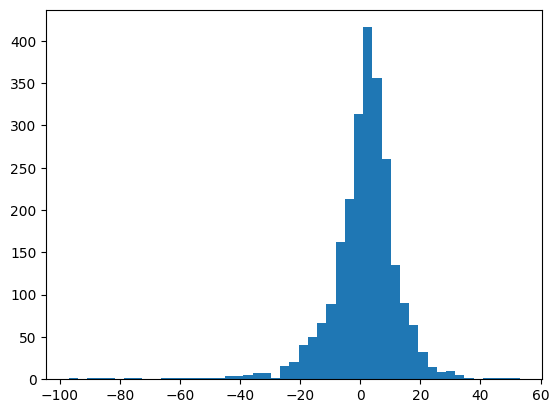

In [ ]:
# fighter_staminas.loc[fighter_staminas['name'] == 'Sean O\'Malley']
import matplotlib.pyplot as plt

plt.hist(fighter_staminas.trend, bins=int(len(fighter_staminas.index)**0.5))